# Pruebas para la Práctica 1 de Aprendizaje Automático 3

In [55]:
"""
- OS para manejo de paths
"""
import os

"""
- JSON para lectura de ".json"
"""
import json

"""
- NumPy para manejo de vectores y matrices
"""
import numpy as np

"""
- Pandas para lectura de .csv
"""
import pandas as pd

"""
- Matplotlib para visualizar datos
"""
import matplotlib.pyplot as plt

"""
- Algoritmos de manifold learning y trustworthiness
  de Scikit-learn
"""
from sklearn.manifold import (
    MDS,
    LocallyLinearEmbedding,
    Isomap,
    TSNE,
    trustworthiness
)

"""
- StandardScaler de Scikit-learn
"""
from sklearn.preprocessing import StandardScaler

"""
- PyTorch para la implementación de Autoencoders
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "cpu"
)

np.random.seed(42)

In [56]:
"""
- Definición de paths relevantes
"""
DATA_PATH = os.path.join("..", "data")
MNIST_PATH = os.path.join(DATA_PATH, "mnist")
F_MNIST_PATH = os.path.join(DATA_PATH, "fashion-mnist")

print("- Conjuntos de datos:")

print("    - MNIST:")
for f in os.listdir(MNIST_PATH):
    print(f"        - {f}")
print()

print("     - Fashion MNIST:")
for f in os.listdir(F_MNIST_PATH):
    print(f"        - {f}")

- Conjuntos de datos:
    - MNIST:
        - mnist_test.csv
        - mnist_train.csv

     - Fashion MNIST:
        - fashion-mnist_test.csv
        - fashion-mnist_train.csv
        - fashion-mnist_label_dict.json


Carga de datos
---
- Cargamos los datos de los ficheros ".csv" de Fashion MNIST descargados de Kaggle.
- Para ello, utilizamos la función `pandas.read_csv()`.

In [57]:
df_train = pd.read_csv(os.path.join(F_MNIST_PATH, "fashion-mnist_train.csv"))
df_test = pd.read_csv(os.path.join(F_MNIST_PATH, "fashion-mnist_test.csv"))

with open(os.path.join(F_MNIST_PATH, "fashion-mnist_label_dict.json")) as f:
    label_dict = json.load(f)
label_dict = {int(k): v for k, v in label_dict.items()}

In [58]:
"""
- Separamos los datasets en etiquetas y datos y los convertimos a np.ndarray
"""
y_train = df_train["label"].to_numpy()
df_train.drop(labels="label", axis=1, inplace=True)
X_train = df_train.to_numpy()

y_test = df_test["label"].to_numpy()
df_test.drop(labels="label", axis=1, inplace=True)
X_test = df_test.to_numpy()

In [59]:
print("- Datos de entrenamiento (X_train):")
print(f"    - Tipo: {type(X_train)}")
print(f"    - Tipo de dato interno: {X_train.dtype}")
print(f"    - Dimensiones:")
print(f"        - {X_train.shape[0]} filas (patrones)")
print(f"        - {X_train.shape[1]} columnas (características/dimensiones)")

- Datos de entrenamiento (X_train):
    - Tipo: <class 'numpy.ndarray'>
    - Tipo de dato interno: int64
    - Dimensiones:
        - 60000 filas (patrones)
        - 784 columnas (características/dimensiones)


In [60]:
print("- Datos de test (X_test):")
print(f"    - Tipo: {type(X_test)}")
print(f"    - Tipo de dato interno: {X_test.dtype}")
print(f"    - Dimensiones:")
print(f"        - {X_test.shape[0]} filas (patrones)")
print(f"        - {X_test.shape[1]} columnas (características/dimensiones)")

- Datos de test (X_test):
    - Tipo: <class 'numpy.ndarray'>
    - Tipo de dato interno: int64
    - Dimensiones:
        - 10000 filas (patrones)
        - 784 columnas (características/dimensiones)


Visualización de datos
---
- Primero, utilizaremos matplotlib para visualizar algunas muestras de cada etiqueta del conjunto de entrenamiento:

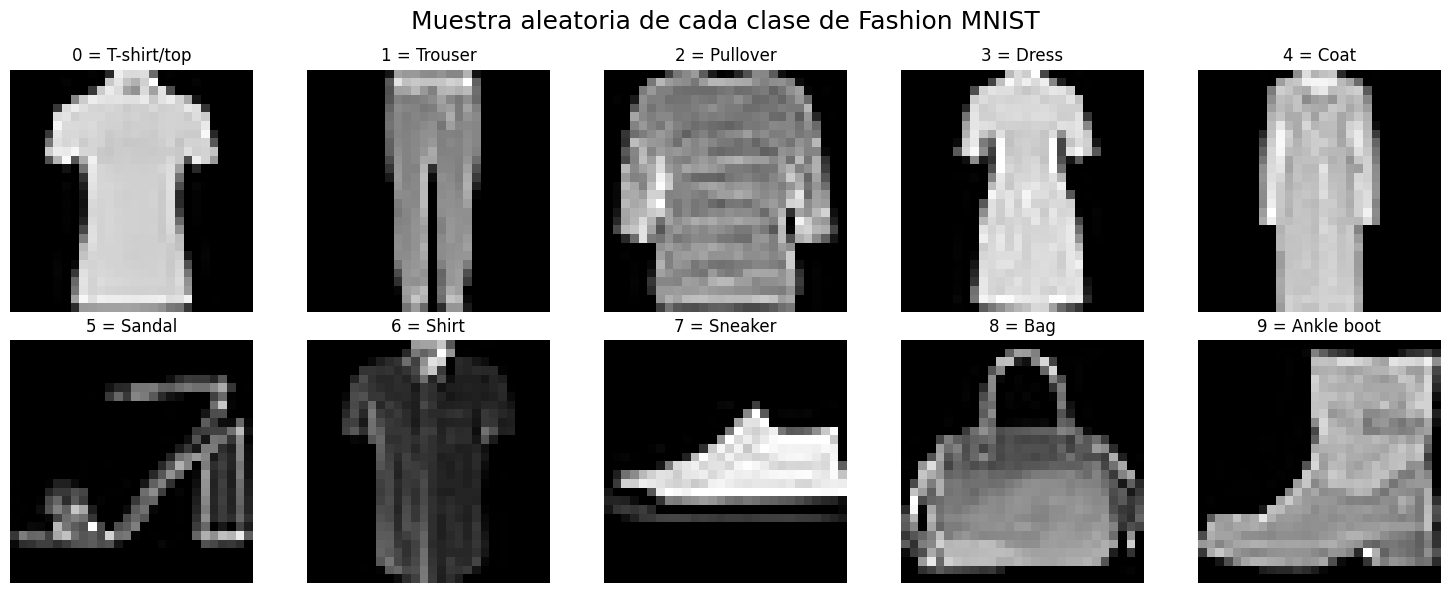

In [61]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Muestra aleatoria de cada clase de Fashion MNIST", fontsize=18)

for k in label_dict.keys():
    idx = np.random.choice(np.where(y_train == k)[0])
    img = X_train[idx].reshape(28, 28)
    ax = axs[k // 5, k % 5]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{k} = {label_dict[k]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Prueba Linear Autoencoder
---

In [62]:
# Estandarizar
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [63]:
class FMNISTDataset(Dataset):
    def __init__(self, data: np.ndarray, labels: np.ndarray):
        self.data = torch.tensor(data, dtype=torch.float32, device=device)
        self.labels = torch.tensor(labels, dtype=torch.int32, device=device)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, index):
        return self.data[index, :], self.labels[index]

In [64]:
train_data = FMNISTDataset(X_train_std, y_train)
test_data = FMNISTDataset(X_test_std, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [65]:
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim=784, embedding_dim=32):
        super(LinearAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=128),
            nn.Linear(in_features=128, out_features=64),
            nn.Linear(in_features=64, out_features=embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=64),
            nn.Linear(in_features=64, out_features=128),
            nn.Linear(in_features=128, out_features=input_dim)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [66]:
model = LinearAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
    for data, _ in train_loader:
        output = model(data)
        loss = criterion(output, data.view(data.size(0), -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, loss = {loss.item()}")

Epoch 1, loss = 0.24304643273353577
Epoch 2, loss = 0.27202966809272766
Epoch 3, loss = 0.2120618224143982
Epoch 4, loss = 0.21165668964385986
Epoch 5, loss = 0.21554699540138245
Epoch 6, loss = 0.19092147052288055
Epoch 7, loss = 0.20973198115825653
Epoch 8, loss = 0.23113283514976501
Epoch 9, loss = 0.24432402849197388
Epoch 10, loss = 0.16369952261447906
Epoch 11, loss = 0.16745133697986603
Epoch 12, loss = 0.19408969581127167
Epoch 13, loss = 0.17655780911445618
Epoch 14, loss = 0.17993827164173126
Epoch 15, loss = 0.44954755902290344
Epoch 16, loss = 0.18219000101089478
Epoch 17, loss = 0.3730716407299042
Epoch 18, loss = 0.24668347835540771
Epoch 19, loss = 0.23280063271522522
Epoch 20, loss = 0.26759570837020874


In [67]:
model.eval()
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32, device=device)
    embeddings_train = model.encoder(X_train_tensor).cpu().numpy()

tsne = TSNE()
tsne_res = tsne.fit_transform(embeddings_train)
tsne_res

array([[ 44.234676,  20.028236],
       [ 51.598927, -60.54232 ],
       [-31.758387,  68.057556],
       ...,
       [ 14.251093, -16.405668],
       [ 42.04423 ,  11.637899],
       [ 18.201221, -96.81095 ]], shape=(60000, 2), dtype=float32)